In [1]:
# sys, file and nav packages:
%load_ext watermark
import os
import datetime as dt


# math packages:
import pandas as pd
import numpy as np
from scipy import stats
import datetime as dt 
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import nbinom
from scipy.stats import gamma
from scipy.stats import beta

# charting:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
import seaborn as sns
import matplotlib.gridspec as gridspec

# documenting
from IPython.display import display, HTML
from IPython.display import Markdown as md
from myst_nb import glue

from resources.empiricaldist import Pmf
import utils
from scipy.stats import norm
import time

# all the data
adata = pd.read_csv("resources/start_data.csv")

dfCodes = pd.read_csv("resources/codes_with_group_names_2015.csv")
dfBeaches = pd.read_csv("resources/beaches_with_land_use_rates.csv")
dfBeaches = dfBeaches[dfBeaches.slug != "clean-up-event-test"]
dfBeaches.set_index("slug", inplace=True)

# dfBeaches = dfBeaches.set_index("slug", drop=True)
wt_map = dfBeaches.water
ct_map = dfBeaches.city
wn_map = dfBeaches.water_name
rb_map =dfBeaches.river_bassin

# all_data = adata.copy()
all_data = adata[adata.river_bassin != 'les-alpes'].copy()
# print(all_data.columns)
columns_i = [
    'loc_date',
    'location',
    'date', 
    'water_name_slug',
    'river_bassin',
    'city',
    'code', 
    'quantity',
    'pcs_m', 
]

all_data["date"] = pd.to_datetime(all_data["date"], format="%Y-%m-%d")

all_data["doy"] = all_data["date"].dt.dayofyear
all_data["date"] = all_data["date"].dt.date

columns_i = [
    'loc_date',
    'location',
    'date',
    'doy',
    'water_name_slug',
    'water',
    'river_bassin',
    'city',
    'code', 
    'quantity',
    'pcs_m', 
]

all_data["water"]= all_data.location.apply(lambda x: wt_map.loc[x])

gfoam = ["G81", "G82", "G83"]
plasticpcs = [ "G78", "G79", "G80", "G75", "G76", "G77"]
Gcaps = [ "G21", "G23", "G24" ]

# the columns that are being kept and the operations per column          
# columns = ['loc_date', 'location', 'city', 'date', 'length', "doy"]
operations = {"quantity":"sum", "pcs_m":"sum"}

# separate the codes of interest by group from the data frame and add the replacement value
all_data_gfrags = all_data[all_data.code.isin(plasticpcs)].groupby(columns_i[:-2], as_index=False).agg(operations)
all_data_gfoam = all_data[all_data.code.isin(gfoam)].groupby(columns_i[:-2], as_index=False).agg(operations)
all_data_gcaps = all_data[all_data.code.isin(Gcaps)].groupby(columns_i[:-2], as_index=False).agg(operations)

all_data_gcaps["code"] = "Gcaps"
all_data_gfoam["code"] = "Gfoam"
all_data_gfrags["code"] = "Gfrags"

# remove the same instances from the work data                                                               
all_data_no_frags = all_data[columns_i][~all_data.code.isin([*plasticpcs, *gfoam, *Gcaps])].copy()

# formatted plastock data
all_data = pd.concat([all_data_no_frags, all_data_gfrags, all_data_gfoam, all_data_gcaps])

all_data = all_data.groupby(columns_i[:-2], as_index=False).agg(operations)
all_data = all_data[~all_data.location.isin(['schiffenensee_duedingen_hirschij', 'sihlsee_einsiedeln_schilligerllacherl', 'lac-leman-hammerdirt'])]

# map to code decriptions
dfCodes.set_index("code", inplace=True)
dfCodes.loc["Gcaps", ["material", "description", "groupname"]] = ["Plastic", "Plastic bottle lids", "food and drink"]
code_d = dfCodes["description"]

# map to material descriptions
mat_d = dfCodes["material"]

# Estimating values

__This is in draft. The methods are correct but the narrative, descriptions and references are being defined. The language needs to be standardized to english, there are several data sources in multiple languages (this is Switzerland)__

The data gathered by the SWE team in 2020 was included in the federal report on shoreline litter density. Since the puplication of IQAASL in December 2021 there has been addtional data collection events on Lac Léman:

1. SWE team
2. Association for the Sauvegarde du Léman completed 100 beach litter surveys in 2022

__Six year sampling period__

The timing of these samples, seven years after the first samples were recorded, could be interpreted as the begining of a new six year sampling period that started in January 2022. The Joint Research Center (JRC) at the EU suggest a six year sampling period with preferably ~ 40 surveys in that time, for each beach that is being monitored. If these conditions are met a baseline value can be established for the location in question. The baseline value, using this method is the median value of the surveys for the time period.

There are over 250 samples in the initial six year period, from 30+ locations on the lake. There are no locations that have 40 surveys, therefore the method described previously would not be appropriate for any single location, but it is more than enough for the lake. Recall that we previously discussed the following:

1. difference between sampling groups
2. correlation between land-use and survey results

## Research questions

__For the lake and Saint Sulpice:__

1. Given the data from 2022, Is there an increase, decrease or no change in the expected survey results given the consolidated results from 2015 - 2021?
2. Given the median value for the objects of interest in 2021, what is the chance that a survey in 2022 will exceed this value?
3. How do the results from 2022 change the expected survey results going forward?

## Practical applications

Investments have been made to either prevent or remove litter from the public space. The investments are made with the intention of reducing litter in the environment. The answers to the research questions should help evaluate the return on investment (ROI) from previous projects and provide insights for projects going forward. 

1. __Did the investment result in a net decline in litter?__
2. __What objects were particularly effected?__
3. __How does the municpality compare to the rest of the lake?__

The prior investments were part of a regional action plan that included all municipal and cantonal administrations on the lake. Therefore, municipal results need to be formulated in the context of the canton and the lake.

## Definitions
1. __threshold:__ The threshold of interest is the median survey result for an object given the data from 2020-2021.
2. __frequency:__ The frequency of exceeding a threshold is the number of times that a threshold was exceeded (k) divided by the number of samples taken (n) or k/n.
3. __land-use or land-cover:__ The common topographical features within a radius of 1500m from each survey location. The land-use is quantified by dividing the surface area attributed to a specific attribute by the total surface area of the hexagon minus the surface area attributed to the lake.
4. __probability:__ The conditional probability of a survey result at a given municipality being equal to or greater than a given threshold.

## Assumptions

1. Locations that have similar environmental conditions will yield similar survey results
2. There is an exchange of material (trash) between the beach and body of water
3. Following from two, the material recovered at the beach is a result of the assumed exchange
4. The type of activities adjacent to the survey location are an indicator of the trash that will be found there
5. Following from four and three, the local environmental conditions are an indicator of the local contribution to the mix of objects at the beach
6. The survey results are a reasonable estimate of the minimum number of objects that were present at the time the survey was completed
7. Surveyors are not 100% accurate, some objects will be misidentified or there will be inaccuracies in some object counts
  
## Method

The litter survey data is count data. The survey results are an aggregation of observations from individuals or groups of varying experience using the same protocol. The collected objects are discarded after the survey, so there is no way to go back and _confirm_ a survey result. Thus, the aggregated data has multiple sources of variance inherent to the collection method and associated infrastructure. This problem is not unique in the natural sciences, conservationists and wildlife biologists estimate populations and trends under similar conditions, over the years these estimations have become more accurate. We use conditional probability because the survey results are subject to many variables. Some of these variables can be attributed to the sampling process such as detectability of the objects at a survey location, correct identification of the objects, accuracy of dimensional data and accuracy of data input. Other variables include the environmental conditions of the survey location and the amount of trash suspened in the water. By this we mean that the variance in survey results between locations is not only due to measuring error.  ([summarizing bird counts](https://www.fs.usda.gov/psw/publications/documents/psw_gtr191/psw_gtr191_0762-0770_sauer.pdf), [estimating age of survival](https://besjournals.onlinelibrary.wiley.com/doi/full/10.1111/2041-210X.14077), [estimating tick abundance](https://hal.science/hal-02637100/))

Condtional probability and Bayes theorem makes it possible to measure the effects of an unknown parameter as long as the conditions can be quantified. There is no assumption about the underlying relationships between variables except that a realtionship exists, $p(a | b)$, the relationship is defined in the notation exist([Bayes' theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem)) ([conditional proabability](https://en.wikipedia.org/wiki/Conditional_probability)). For this study we are using Bayes theorem in its simplest form to answer the stated research questions. A probability mass function (pmf) is constructed under different conditions (priors) for each code. The limits of the pmf are defined as  $0 \le x \le 9.99$ and $0.01 \le y \le 0.99$. This accounts for 99% of the data and is computationaly effcient. The x scale corresponds to pieces per meter, multiplying * 100 gives an integer representation of the expected result.

### Conditional probability

Conditional probability is the measure of the probability of an event occuring given that another event has occurred ([Wikepedia](https://en.wikipedia.org/wiki/Conditional_probability)). For this study the event under consideration is whether or not the threshold was exceeded. The probability of that event is noted $p(\theta)$, the probability of $\theta$ given a condition or set of condtions is $p(\theta | condition(s))$. 

__The general case__

Using the formal definition of conditional probability let a = $\theta$ and b = _event data_, the probability of an event given a condtion is:

$$ 
\begin{align}
p(a | b) =&\ \frac{p(a \cap b)}{p(b)},\ 0.01 \le a \le 0.99,\ 0.01 \le b \le 0.99\\[10pt]
and&\\
p(b | a) =&\ \frac{p(b \cap a)}{p(a)}\\[10pt]
note&\\
p(a \cap b) =&\ p(b \cap a)\\[10pt]
therefore&\\
p(b | a) =&\ \frac{p(b \cap a)}{p(a)}\ =\ \frac{p(a \cap b)}{p(a)}\\[10pt]
p(a)p(b|a) =&\ p(a \cap b)\\[10pt]
finally&\\
p(a | b) =&\ \frac{p(a)p(b|a)}{p(b)}\\
\end{align}
$$

This is Bayes theorem, it tells us that the probability of event _a_ happening given event _b_ is equal to the probability of event _a_ times the the probability of event _b_ given _a_ divided by the probability of _b_. There is a standard nomenclature for the different values in Bayes theorem.
$$
\begin{align}
posterior =&  \frac{likelihood*prior}{marginal\ probability}\\ \\
posterior =&\ p(a | b) =\ \text{The probability of exceeding the threshold given the conditions, the question we are trying to answer.}\\[10pt]
likelihood =&\ p(b|a) =\ \text{The probability of exceeding the threshold given theta. The current set of data.}\\[10pt]
prior =&\ p(a) =\ \text{The expected probability given previous studies. Before considering the likelihood}\\[10pt]
\text{marginal probability} =&\ p(b) =\ \text{The probability of the data without any conditions}
\end{align}
$$

Bayes theorem is used extensively in machine learning. Many processes have been optimized for data pipelines ([Scikit Naive Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html)) and solving Generalized Linear Models ([Bayesian regression models using Stan](https://paul-buerkner.github.io/brms/)). Fully developed, the proposed model is similar to a Bayesian Neural Network ([Deep Learning](https://arxiv.org/pdf/2007.06823.pdf)).

### The priors

The priors refers to the assumptions or expected results before new evidence is taken into account ([wikepedia](https://en.wikipedia.org/wiki/Prior_probability)). 

> With well-identified parameters and large sample sizes, reasonable choices of prior distributions will have minor effects on posterior inferences. This definition of ‘well identified’ and ‘large’ sample size might seem to be circular, but in practice one can check the dependence on prior distributions by a sensitivity analysis: comparing posterior inferences under different reasonable choices of prior distribution (and, for that matter, different reasonable choices of probability models for data). ([Gelman prior distribution](http://www.stat.columbia.edu/~gelman/research/published/p039-_o.pdf))

> If the sample size is small, or available data provide only indirect information about the parameters of interest, the prior distribution becomes more important. In many cases, however, models can be set up hierarchically, so that clusters of parameters have shared prior distributions, which can themselves be estimated from data. ([Gelman prior distribution](http://www.stat.columbia.edu/~gelman/research/published/p039-_o.pdf))

The data for this study falls into the second case for any particular municipality or location. How well the density is modeled at the lake level is also complex because of the differences in magnitude and type of inputs for any particular lake. To accomodate small sample sizes a shared prior distribution can be created that is based on the environmental conditions adjacent to the survey location. 

> __Environmental conditions:__ are the measurable characteristics defined by or derived from an accurate topographic map.

The connection between measurable land-use attributes and survey results was illustrated in the swiss national survey ([IQAASL](https://hammerdirt-analyst.github.io/IQAASL-End-0f-Sampling-2021/land_use_correlation.html)) and explored in depth, including early versions of the proposed model in [Near or far](https://hammerdirt-analyst.github.io/landuse/titlepage.html). The source of the land-use data is [swissTLMRegio](https://www.swisstopo.admin.ch/de/geodata/landscape/tlmregio.html), the details of extracting the data and defining the boundary conditions can be found here [New map data](https://hammerdirt-analyst.github.io/landuse/hex-3000-m.html). 

#### Measured environmental conditions

*__Note:__ There are slight changes in the way the land-use variables are handled and described with respect to [Near or far](https://hammerdirt-analyst.github.io/landuse/titlepage.html). Notably the infrastruture and recreation variables are scaled separately from the land-cover variables.* 

__land-cover__

These measured environmental conditions are the labeled polygons from the map layer _Landcover_ defined here ([swissTLMRegio product information](https://www.swisstopo.admin.ch/fr/geodata/landscape/tlm3d.html#dokumente)), they are extracted using vector overlay techniques in QGIS ([QGIS](https://qgis.org/en/site/)). The overlay is a hexagon-grid, each hex is 3000m, circumcscribed by a circle r=1500m. The survey location is located at the center of the hex. The magnitude of the land-use variable is the portion of the total dry surface area for any particular land-use attribute. Areas of the hex that are not defined with a land-use attribute in this map layer are labeled _undefined_ and processed like any other land-use attribute. The land-cover variables of interest are:

1. Buildings: built up, urbanized
2. Woods: not a park, harvesting of trees may be active
3. Vineyards: does not include any other type of agriculture
4. Orchards: not vineyards
5. Undefined: areas of the map with no predefined label

__Land-use__

Land-use variables are the labled polygons from the _Freizeitareal_ and  _Nutzungsareal_ map layers, defined in ([swissTLMRegio product information](https://www.swisstopo.admin.ch/fr/geodata/landscape/tlm3d.html#dokumente)). Both layers represent areas used for specific activities. Freizeitareal identifies areas used for recreational purposes and Nutzungsareal represents areas such as hospitals, cemeteries, historical sites or incineration plants. As a ratio of the available dry-land in a hex, these features are relatively small (less than 10%) of the total dry-land. For identified features within a bounding hex the magnitude in meters² of these variables is scaled between 0 and 1, thus the scaled value represents the size of the feature in relation to all other measured values for that feature from all other hexagons.

1. Recreation: parks, sports fields, attractions
2. Infrastructure: Schools, Hospitals, cemeteries, powerplants

__Streets and roads__

Streets and roads are the labled polylines from the _TLM Strasse_ map layer defined in ([swissTLMRegio product information](https://www.swisstopo.admin.ch/fr/geodata/landscape/tlm3d.html#dokumente)). All polyines from the map layer within a bounding hex are merged (disolved in QGIS commands) and the combined length of the polylines, in meters, is the magnitude of the variable for the bounding hex.

Each survey location has a unique combination of land-use and land-cover variables. The uniqueness stems from the fact that no calculated surface area is exactly the same. In relation to all other survey locations Saint Sulpice is urbanized, has very little undefined land use, little space attributed to forests and an elevated amount of land attributed to infrastructure, (fig 2). The mix of environmental conditions at Saint Sulpice correspond to the expected mix of land-use and land-cover given the table of correlations in fig 3. Specifically we note high levels of buildings and low levels of woods and undefined land.

In [2]:
def check_nk(anarray, threshold):
    gthan = (anarray >= threshold).sum()
    pnk = gthan/len(anarray)

    return pnk, gthan, len(anarray)


def a_nbdist(anarray):
    mu = anarray.mean()
    sigma = anarray.var()

    p = mu/sigma    
    n = mu**2/(sigma-mu)

    nbrv = nbinom(n,p)

    return nbrv
    
    
def a_gammadist(anarray, afunc: callable = None):

    if afunc is not None:
        mu = afunc(anarray)
    else:
        if np.median(anarray) == 0:
            mu = .001
        else:
            mu = np.median(anarray)

    gammadist = gamma(mu)

    return gammadist


def make_date_object(astring):
    fmat = "%Y-%m-%d"

    an_obj = dt.datetime.strptime(astring, fmat).date()   

    return an_obj

def make_post(row):
    # print(row)
    k = row["k"]
    n =row["n"]
    if k == 0:
        n+=1
        k+=1
    ks = k+row["kl"]
    ns = n + row["kn"]
    nmk = ns-ks
    if nmk == 0:
        nmk = 1
    amean = beta(k,nmk).mean()

    
    return amean

def results_and_land_use(all_data, land_use_agg, slr_e, prior_locations, codes):
    # the survey results from all the data prior to the date defined by slr_e
    # and from locations on lakes. Includes only the codes of interest
    # returns two dataframes
    p_results = all_data[(all_data.date <= slr_e)&(all_data.water == "l")]
    p_results = p_results[p_results.code.isin(codes)]

    # the landuse values for all the locations in p_results
    p_ludata = land_use_agg.loc[prior_locations]
    

    return p_results, p_ludata

def rtn_a_float_between_0_and_one(x, afloat=0.5):
    return afloat

def rtn_an_array_between_01_and_99(array):
    wexp = [x if x > 0 else .01 for x in array]
    wexp = [x if x < 1 else .99 for x in wexp]
    return wexp


def rtn_df_with_lhood_prior_and_post(c,  prior="npr"):

    d=c.copy()
    
    d["1-lh"] = 1 - d.lh
    d[f"1-{prior}"] = 1 - d[prior]
    
    
    d[f"lh*{prior}"] = d.lh * d[prior]
    d[f"1-lh*1-{prior}"] =d[f"1-{prior}"]* d["1-lh"]
    d["p-total"] = d[f"lh*{prior}"]+d[f"1-lh*1-{prior}"]
    
    d["post"] = d[f"lh*{prior}"]/d["p-total"]

    return d    
    

def range_likelihood_prior_df(current, prior, code, xrange, afunc=rtn_a_float_between_0_and_one):

    cr = current[current.code == code].pcs_m.values
    # cr = np.sort(cr)
    kl = [(cr >= x).sum() for x in xrange]
    kn = [len(cr) for x in xrange]
    
    lhood = np.array([(cr >= x).sum()/len(cr) for x in xrange])
    lhood = rtn_an_array_between_01_and_99(lhood)

    if isinstance(prior, pd.core.frame.DataFrame):
        if "code" in prior.columns:
            # print("there is a code")
            pr = prior[prior.code == code].drop_duplicates(["loc_date", "code"])
            pr = pr.pcs_m.values
            pr = np.sort(pr)
            k = [(pr >= x).sum() for x in xrange]
            n = [len(pr) for x in xrange]
            cprior = np.array([x/len(pr) for x in k])
            # print("cprior", cprior
            cprior = rtn_an_array_between_01_and_99(cprior)

            data = pd.DataFrame({"qty":xrange, "lh":lhood, "pr": cprior, "k": k, "n": n, "kl":kl, "kn":kn})
            data["post_beta"] = data.apply(lambda row: make_post(row), axis=1)

            return data
        else:
            cprior = prior.post.values
    else:
        cprior = rtn_an_array_between_01_and_99(prior)
    
    
        

       

    data = pd.DataFrame({"qty":xrange, "lh":lhood, "pr": cprior})

    return data

def an_array_of_posterior_probabilities(lagi, prior_year, codes, xrange):

    dfs = []
    for i, code in enumerate(codes):
        informed = range_likelihood_prior_df(lagi, prior_year, code, xrange)
        
        informed_posterior = rtn_df_with_lhood_prior_and_post(informed,  prior="pr")
      
        dfs.append(informed_posterior)
    return dfs

def an_array_of_sequential_probabilities(lagi, prior_year, codes, xrange):

    dfs = []
    for i,code in enumerate(codes):
        informed = range_likelihood_prior_df(lagi, prior_year[i], code, xrange)
        
        informed_posterior = rtn_df_with_lhood_prior_and_post(informed,  prior="pr")
       
        dfs.append(informed_posterior)
    return dfs

def survey_results_with_land_use(survey_results, land_use_data, locations):
    
    lu = land_use_data.loc[locations][["use", "binned"]]
    lu = lu.pivot(columns="use").fillna(0)
    lu = lu.droplevel(0, axis=1)
    lu.index.name = None

    data = survey_results.merge(lu, left_on="location", right_index=True, validate="many_to_one")

    return data

class SurveyResults:

    def __init__(self, start_date, end_date, lake, current_locations, codes_of_interest):
        self.prior_data = None
        self.prior_locs = None
        self.land_use_data = None
        self.start_date = start_date
        self.end_date = end_date
        self.lake = lake
        self.current_locs = current_locations
        self.current_data = None
        self.cois = codes_of_interest
        

    def prior_locations(self, data):
        d = data[(data["date"] <= self.end_date)&(data.water == "l")]
        self.prior_locs = d.location.unique()

    def prior_and_current_data(self, data, land_use_data):
        p_results, p_ludata = results_and_land_use(data, land_use_data, self.end_date, self.prior_locs, self.cois)
        # self.prior_data = p_results
        self.land_use_data = p_ludata
        c_results = p_results[p_results.date >= self.start_date].copy()
        self.current_data = survey_results_with_land_use(c_results, p_ludata, self.current_locs)
        self.prior_data = survey_results_with_land_use(p_results, p_ludata, self.prior_locs)

class PosteriorForDateRange:
    def __init__(self, current_data, prior_data, thresholds, codes_of_interest, xrange, prior_series: list = None, uninformed: list=None):
        self.current_data = current_data
        self.prior_data = prior_data
        # self.prior_class = prior_class
        self.cois = codes_of_interest
        self.xrange = xrange
        self.prior_series = prior_series
        self.uninformed = uninformed
        self.thresholds = thresholds
        self.sequential = None
        self.post_informed = None
        self.post_uninformed = None
        self.post_sequential = None
        self.shared = None
    
    def prior_shared(self, b):
        a =self.current_data.copy()
        # b = self.prior_class.twotest_post.shared
        t = an_array_of_posterior_probabilities(a, b, self.cois, self.xrange)
        post = np.round([t[i].loc[int(self.thresholds.loc[x])]["post"] for i, x in enumerate(self.cois)], 2)
        self.shared = t
        self.post_informed = post
        
    
    def prior_sequential(self):
        if isinstance(self.prior_series, (list, np.ndarray)):
            st = an_array_of_sequential_probabilities(self.current_data, self.prior_series, self.cois, self.xrange)
            post = np.round([st[i].loc[int(self.thresholds.loc[x])]["post"] for i, x in enumerate(self.cois)], 2)
            self.sequential = st
            self.post_sequential = post
        else:
            print("There is no prior series specified: no operation")        
    
    def prior_uninformed(self):
        qt = an_array_of_posterior_probabilities(self.current_data, self.uninformed, self.cois, self.xrange)
        post = np.round([qt[i].loc[int(self.thresholds.loc[x])]["post"] for i, x in enumerate(self.cois)], 2)
        self.uninformed = qt
        self.post_uninformed = post

    def table_display(self):
        table_data = []
        for aseries in [self.post_informed, self.post_uninformed, self.post_sequential]:
            if aseries is not None:
                table_data.append(aseries)
            else:
                pass

        a_display_table = pd.DataFrame(data=table_data, columns=self.cois)

        return a_display_table


class GridApproximation:
    
    def __init__(self, slr_d, slr_e, lake, lake_locations, cois, all_data, land_use_agg, tholds_r, xrange, prior_series=None, uniformed_prior=None):
        self.testwo = SurveyResults(slr_d, slr_e, lake, lake_locations, cois)
        self.testwo.prior_locations(all_data)
        self.testwo.prior_and_current_data(all_data, land_use_agg)
        self.uses = self.testwo.land_use_data.use.unique()
        self.testwo_post = PosteriorForDateRange(self.testwo.current_data, self.testwo.prior_data, tholds_r, cois, xrange, prior_series, uniformed_prior)
        # self.testwo_post.prior_shared()
        self.testwo_post.prior_uninformed()
        self.testwo_post.prior_sequential()


def when_k_is_zero(k, n):

    if k == 0:
        return .01
    else:
        kn = k/n

        if kn == 1:
            return .99
        else:
            return kn
    

def y_exceeds_x_one_code_bin_category(data, apmf):
    n = len(data)
    apmf["k"] = apmf.x.apply(lambda j: (data.pcs_m >= j).sum())
    apmf["theta"] = apmf.k.apply(lambda x: when_k_is_zero(x, n))
    # print(apmf.head())
        
    return apmf




def make_prior_by_use(data, xtest, profiles_dict, keep_copy=True):

    ud = []
    prior = np.ones(len(xtest))
    
    for k, v in profiles_dict.items():
        # print(k)
        str = data[(data[k].isin(v))].copy()
        # print(str.pcs_m.describe())
        use_dist = y_exceeds_x_one_code_bin_category(str, xtest)
        if keep_copy:
            ud.append((use_dist, str))
            
        # print("\n usedist: \n")
        # print(use_dist.theta.mean())
        # print(use_dist.theta.min(), use_dist.theta.max())
        # print("\n prior: \n")
        # print(prior.mean())
        # print(len(prior))
        # print(prior.min(), prior.max())
        prior *= use_dist.theta

    return prior, ud

def land_use_profile_from_data(tdata, code, uses):
    profile_data = tdata[(tdata.code == code)]
    lprofiles = list(set(profile_data.columns).intersection(uses))
    profiles_dict = {x:profile_data[x].values for x in lprofiles}

    return profile_data, profiles_dict



In [3]:
# these are the land use values for each hex
# nutuzungsareal and freizeit areal are totaled
# the surface area of these two use cases gets added
# to the total of the land cover surface area
dfln = pd.read_csv("resources/geodata/infrastructure.csv")
dflf = pd.read_csv("resources/geodata/recreation.csv")
locations = all_data.location.unique()

# rename the columns and total the surface are for each component
dflf.rename(columns={"OBJEKTART":"use"}, inplace=True)
dflf = dflf[~dflf.use.isin(['Reben', 'Obstanlage'])].copy()
dflf_t = dflf.groupby(["slug", "city", "water_name", "water"], as_index=False).area.sum()
dflf_t["use"] = "recreation"
dflf_t["scaled"] = (dflf_t["area"] - dflf_t["area"].min())/(dflf_t["area"].max() - dflf_t["area"].min())

dfln.rename(columns={"OBJEKTART":"use"}, inplace=True)
dfln = dfln[~dfln.use.isin(['Reben', 'Obstanlage'])].copy()
dfln_t = dfln.groupby(["slug", "city", "water_name", "water"], as_index=False).area.sum()
dfln_t["use"] = "infrastructure"
dfln_t["scaled"] = (dfln_t["area"] - dfln_t["area"].min())/(dfln_t["area"].max() - dfln_t["area"].min())

rec_inf = pd.concat([dfln_t, dflf_t])
rec_inf = rec_inf[rec_inf.slug.isin(locations)]
rec_inf.rename(columns={"area":"magnitude"}, inplace=True)

dflc = pd.read_csv("resources/geodata/landcover.csv")
dflc = dflc[dflc.slug.isin(locations)].copy()

# sum the unique land cover values for each location
area_of_a_hex = 5845672
xgr = dflc.groupby(["slug", "city", "water_name", "OBJVAL", "water"], as_index=False, dropna=False).area.sum()

# the sum of all the land cover values for a location
xgrt = xgr.groupby(["slug", "city", "water_name", "water"], as_index=False).area.sum()

# the amount of surface area that is not accounted for 
xgrt["undefined"] = area_of_a_hex - xgrt.area

# format data frame to join to the other land cover totals
xgrt["OBJVAL"] = "undefined"
xgrt["area"] = xgrt["undefined"]
xgrt.drop("undefined", inplace=True, axis=1)

# add to other totals
dflcx = pd.concat([xgr, xgrt])

# remove the value of See from the surface area of a hex.
# We are considering the magnitude of land use type in relation
# to the amount of land that is available to be used, not including 
# amount of land that is covered by the lake itself
# xsee = xgr[xgr.OBJVAL == "See"][["slug", "area"]]
# xsee["hex minus"] = area_of_a_hex - xsee.area
# hex_minus = xsee[["slug", "hex minus"]].set_index("slug", drop=True)
xgr_l = xgr[xgr.water == "l"].copy()
xgr_r = xgr[xgr.water == "r"].copy()
xgr_r["hex minus"] = area_of_a_hex

xsee = xgr_l[xgr_l.OBJVAL == "See"][["slug", "area"]]
xsee["hex minus"] = area_of_a_hex - xsee.area
hex_minus = xsee[["slug", "hex minus"]].set_index("slug", drop=True)


hex_not_minus = xgr_r[["slug", "hex minus"]].drop_duplicates("slug").set_index("slug", drop=True)
# hex_not_minus.drop_duplicates(inplace=True)
xsee_all = pd.concat([hex_not_minus, hex_minus])

# map the adjusted surface area to to the land use
# totals and scale the surface column to the adjusted surface area
dflcx["hex minus"] = dflcx.slug.apply(lambda x: xsee_all.loc[x, "hex minus"])
# rec_inf["hex minus"] = rec_inf.slug.apply(lambda x: xsee_all.loc[x, "hex minus"])
# change column name
dflcx.rename(columns={"OBJVAL":"use"}, inplace=True)

land_cover = dflcx.copy()

land_cover["scaled"] = land_cover.area/land_cover["hex minus"]

# remove See from the data frame
land_cover = land_cover[land_cover.use != "See"]

bind = pd.IntervalIndex.from_tuples([(-1, 0), (0.0000001, .0499999), (.0500000, .0999999), (.1000000, .1499999),(.1500000, .1999999), (.2, .2499), (.25, .2999), (.3000, .3499),
        (.35, .3999), (.4000, .449999), (.45, .499999),(.5, .549999), (.55, .5999), (.6000, .6499), (.65, .6999), (.7, .7499), (.75, .7999),
        (.8, .8499), (.85, .8999), (.9, .9499), (.95, 1)])

# bin the scaled column
sbins = pd.cut(land_cover.scaled, bins=bind, labels=np.arange(start=0, stop=21), include_lowest=True, retbins=False)
sbins=sbins.cat.rename_categories(np.arange(start=0, stop=21))

rbins = pd.cut(rec_inf.scaled, bins=bind, labels=np.arange(start=0, stop=21), include_lowest=True, retbins=False)
rbins=rbins.cat.rename_categories(np.arange(start=0, stop=21))
rec_inf["binned"] = rbins

merge_columns = ["slug", "city", "water_name", "water", "magnitude", "use", "scaled", "binned"]
land_cover["binned"] = sbins
land_cover.rename(columns={"area":"magnitude"}, inplace=True)
merge_df = land_cover[merge_columns]
agg_land_use = pd.concat([rec_inf, merge_df])

dist_ct = pd.read_csv("resources/geodata/intersect_length.csv")
dist_ct = dist_ct.groupby(["slug","city", "water_name", "water", "NAMN"], as_index=False).length.sum()
dist_ct[dist_ct.slug == "mullermatte"]

dist_dt = pd.read_csv("resources/geodata/d_to_intersect.csv")

dist_dt["water"] = dist_dt.slug.apply(lambda x: wt_map.loc[x])
dist_dt["city"] = dist_dt.slug.apply(lambda x: ct_map.loc[x])
dist_dt["water_name"] = dist_dt.slug.apply(lambda x: wn_map.loc[x])
dist_dt = dist_dt.groupby(["slug", "NAMN", "water", "city", "water_name"], as_index=False).dist.sum()

dr = dist_dt[dist_dt.water == "r"].copy()
dr["dist"] = 0

dnr = dist_dt[dist_dt.water != "r"].copy()
dist_dt = pd.concat([dnr, dr])
dist_dt = pd.melt(dist_dt, id_vars = ["slug", "NAMN", "water", "city", "water_name"], value_vars=["dist"])
dist_ct = pd.melt(dist_ct, id_vars = ["slug", "NAMN", "water", "city", "water_name"], value_vars=["length"])

# river network and disttance to intersection
dist_it_len = pd.concat([dist_dt, dist_ct])

# min max scale
dist_it_len["scaled"] = (dist_it_len["value"] - dist_it_len["value"].min())/(dist_it_len["value"].max() - dist_it_len["value"].min())
# bin in groups of 0.05 plus one bin for zero
sbinsr = pd.cut(dist_it_len.scaled, bins=bind, labels=np.arange(start=0, stop=21), include_lowest=True, retbins=False)
sbinsr=sbinsr.cat.rename_categories(np.arange(start=0, stop=21))
dist_it_len["binned"] = sbinsr
dist_it_len.rename(columns={"variable":"use", "value":"magnitude"}, inplace=True)
dist_it_len.set_index("slug", inplace=True, drop=True)

strasse = pd.read_csv("resources/geodata/streets.csv", low_memory=False)
strasse = strasse[strasse.slug.isin(locations)].copy()
strasse.fillna(0, inplace=True)
stras = strasse.groupby(["slug", "water_name", "city", "water"], as_index=False)["street len"].sum()

# min max scale
stras["scaled"] = (stras["street len"] - stras["street len"].min())/(stras["street len"].max() - stras["street len"].min())
sbinsras = pd.cut(stras.scaled, bins=bind, labels=np.arange(start=0, stop=21), include_lowest=True, retbins=False)
sbinsras=sbinsras.cat.rename_categories(np.arange(start=0, stop=21))
stras["binned"] = sbinsras
stras["use"] = "Strasse"
stras.rename(columns={"street len":"magnitude"}, inplace=True)

land_use_agg = pd.concat([stras, agg_land_use])
land_use_agg.fillna(0, inplace=True)
land_use_agg.set_index("slug", drop=True, inplace=True)
collection_points = dfBeaches[dfBeaches.water == "l"].water_name_slug.unique()

In [4]:
st_sulpice = land_use_agg.loc[(land_use_agg.city=="Saint-Sulpice (VD)")]
sp = st_sulpice[["magnitude", "scaled", "binned", "use"]]
uses = sp.use.unique()

tcols = ["binned", "scaled", "magnitude", "use"]
tst = land_use_agg[[*tcols, "water_name"]]
tst = tst[tst.water_name == wn_map.loc["plage-de-st-sulpice"]]
tst = tst[~tst.use.isin(["Geroell", "Stausee"])]
tstx = tst.pivot(columns="use", values="scaled").fillna(0)

corr = tstx.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

ax = axs[0]
sns.boxplot(data=land_use_agg[land_use_agg.use.isin(uses)], x="use", y="scaled", ax=ax)
sns.stripplot(data=sp, x="use", y="scaled", ax=ax, color="magenta", label="Saint-Sulpice (VD)")
ax.set_title("Distribution of measured variables", loc="left")
ax.tick_params(axis='x', labelrotation = 90)
ax.set_xlabel(" ")
h, l = ax.get_legend_handles_labels()
ax.legend([h[0]], [l[0]])

sns.heatmap(corr, mask=mask, cmap="YlOrBr", ax=axs[1])

axs[1].set_ylabel("")
axs[1].set_xlabel("")
axs[1].set_title("Correlation of measured variables", loc="left")
plt.tight_layout()

glue("land_use_dist", fig, display=False)
plt.close()

```{glue:figure} land_use_dist

Distribution and correlation of measured environmental variables
``` 

__The land-use profile of a survey location__ is the unique combination of the measured attributes. For example at the _plage-de-saint-sulpice_ 97% of the dry land is occupied buildings, the rest is either woods (2%) or undefined < 1%. In relation to all other survey locations there is more land attributed to infrastructure and less attributed to recreation (table 2). The column _binned_ is the percentile group that the measured-value corresponds to when all survey locations are considered. Recall that the measured variables are grouped by intervals of 0.05, from the scaled column. Therefore, the amount of land attributed to infrstructure at _plage-de-saint-sulpice_ is greater than 70% of all other locations and the amount of land atrributed to buildings is greater than 95% of all other survey locations. Conversely at _plage-de-saint-sulpice_ the amount attributed to woods is less than 95% of all other locations.

In [5]:
cois = [
    'Gfrags', 'G30', 'G27', 'Gfoam', 'G95', 'Gcaps', 'G67', 'G35', 'G89',
    'G31', 'G32', 'G100', 'G33', 'G25', 'G70', 'G10'
]

# this defines the css rules for the note-book table displays
header_row = {'selector': 'th:nth-child(1)', 'props': f'background-color: #FFF; text-align:right'}
even_rows = {"selector": 'tr:nth-child(even)', 'props': f'background-color: rgba(139, 69, 19, 0.08);'}
odd_rows = {'selector': 'tr:nth-child(odd)', 'props': 'background: #FFF;'}
table_font = {'selector': 'tr', 'props': 'font-size: 12px;'}
table_data = {'selector': 'td', 'props': 'padding: 6px;'}
table_caption = {'selector': 'caption', 'props': 'font-size: 14px; font-style: italic; caption-side: bottom; text-align: left; margin-top: 10px'}
table_css_styles = [even_rows, odd_rows, table_font, header_row, table_caption]

# thresholds
thold_data = all_data[(all_data.date >= make_date_object("2020-04-01"))&(all_data.date <= make_date_object("2021-05-01"))]
thold_data = thold_data[thold_data.water_name_slug == "lac-leman"]
thold_data = thold_data[thold_data.code.isin(cois)]
# thold_data = thold_data.groupby(["loc_date", "code"], as_index=False).pcs_m.sum()
tholds = thold_data.groupby(["code"]).pcs_m.median()
tholds_r = (tholds * 100).round()
thold_data["object"] = thold_data.code.apply(lambda x: code_d.loc[x])
tholdsx = thold_data.groupby(["code", "object"], as_index=False).pcs_m.median()
tholdsx.rename(columns={"pcs_m":"threshold"}, inplace=True)
tholdsx.set_index("code", drop=True, inplace=True)
tholdsx.index.name = None

In [6]:
# data for the initial sampling period
# the dates of the sampling period
# the start and end date
slr_d, slr_e = make_date_object("2015-11-15"), make_date_object("2016-11-14")

# the date range of the samples
date_mask = (all_data["date"] >= slr_d) & (all_data["date"] <= slr_e)

# likelihood: the locations from the lake of interest that were surveyed during the time frame
# these locations furnish the data for the likelihood, they make up the current results
lake_locations = all_data[date_mask & (all_data.water_name_slug == 'lac-leman')].location.unique()

xrange =  np.arange(0.01, 10, step=.01)
xtest = pd.DataFrame(data=xrange, columns=["x"])
xtesti = xtest.copy()

uniformed_prior = [0.5 for x in xrange]

lake = "lac-leman"
coi = "Saint-Sulpice (VD)"
code = "Gfrags"
    
yearone = GridApproximation(slr_d, slr_e, lake, lake_locations, cois, all_data, land_use_agg, tholds_r, xrange, uniformed_prior=uniformed_prior)

tdata = yearone.testwo.prior_data  
uses = yearone.testwo.land_use_data.use.unique()


# sample totals per code all lake locations
cstart = yearone.testwo.current_data.groupby(["loc_date", "date", "code"], as_index=False).pcs_m.sum()
ctot = cstart.groupby(["loc_date", "date"], as_index=False).pcs_m.sum()
city_results = yearone.testwo.current_data[yearone.testwo.current_data.city == coi]

# sample totals per code all locations in city
city_tot = city_results.groupby(["loc_date", "date"], as_index=False).pcs_m.sum()
city_start = city_results.groupby(["loc_date", "date", "code"], as_index=False).pcs_m.sum()

cmedian = cstart.groupby("code", as_index=False).pcs_m.mean()

There is no prior series specified: no operation


In [7]:
profile_data, profiles_dict =  land_use_profile_from_data(tdata, code, uses)  
gradient_p, ud = make_prior_by_use( tdata[(tdata.code == code)], xtest, profiles_dict)

xtesti["gradient_p"] = gradient_p

parc_pier =  tdata[(tdata.code == code) & (tdata.location == "parc-des-pierrettes")]
profile_data_pp, profiles_dict_pp =  land_use_profile_from_data(parc_pier, code, yearone.uses)  
gradient_pp, udp = make_prior_by_use(tdata[(tdata.code == code)], xtest, profiles_dict_pp)

xtesti["prior_use_pp"] = gradient_pp

data = tdata[tdata.code == "Gfrags"]
prior = np.ones(len(xrange))
ud = []

for k, v in profiles_dict.items():   
    
    str_i = data[(data[k].isin(v))].copy()
   
    use_dist_i = y_exceeds_x_one_code_bin_category(str_i, xtest)
    ud.append((use_dist_i, str_i))        
  
    prior *= use_dist_i.theta
    
xtesti["apriori_i"] = prior

In [8]:
caption="Table 1: Land use profile of plage-de-saint-sulpice"
table_one = yearone.testwo.land_use_data.loc["plage-de-st-sulpice"][["use","magnitude", "scaled", "binned"]]
table_one.set_index("use", inplace=True, drop=True)
table_one.index.name = None
table_one.style.set_caption(caption).set_table_styles(table_css_styles)

,magnitude,scaled,binned
Strasse,65518,0.313693,7
infrastructure,1022280,0.734544,15
recreation,99620,0.174540,4
Siedl,2905921,0.975773,20
Wald,64229,0.021567,1
undefined,7921,0.002660,1


#### Sequential priors

Sequential priors use the uninformed posterior distribution (next section) from the previous sampling campaign for the prior of the current sampling campaign. This amounts to considering only the numerical result of the previous surveys and not including survey results from similar locations.

#### Uninformed (uniform) priors

Uninformed priors are probability distributions that should not influence the expected probability distribution that is derived from the likelihood. In other words, each sampling period is considered a new experience and their is no complentary information to add that might change our expectations. In this study each calculation is a binary result, therefore we use 0.5 to represent the condition that we have no expectation that a particular survey results will exceed a given threshold.

#### Priors: summary

Using the notation from equation 6 (Bayes theorem) the effect of the different priors on the expected results can be assessed directly, equations 7-9 demonstrate the different calculations for each prior at each aggregation level.

$$
\begin{align}
p(\theta | \text{survey data}) =&\ \frac{p(\text{environmental conditions})p(\text{survey data}|\theta)}{p(\text{survey data})}\\[10pt]
p(\theta | \text{survey data}) =&\ \frac{p(\text{previous results})p(\text{survey data}|\theta)}{p(\text{survey data})}\\[10pt]
p(\theta | \text{survey data}) =&\ \frac{p(\text{uninformed})p(\text{survey data}|\theta)}{p(\text{surveydata})}\\[10pt]
\end{align}
$$



## Codes of interest

The codes of interest were chosen because they appear in the 2022 results. It was just luck that there are compatible test data for the model based on the previous survey results. The sampling campaign from 2022 did not involve the authors of this study, thus it is truly an independent test of the sampling methods and proposed model. Collectively these 16 codes account for 76% of the objects identified in 2022, 67% of the objects in 2021 and 58% of the objects found by team SWE. From a machine learning standpoint the 2022 results are the test data to the training data that was collected between 2015 and 2021.

In [9]:
# the unique land use categories in the current data set
caption = "Table 2: Objects of interest and the median survey results from 2021."
tholdsx.style.set_caption(caption).set_table_styles(table_css_styles)

,object,threshold
G10,Food containers single use foamed or plastic,0.010000
G100,Medical; containers/tubes/ packaging,0.020000
G25,"Tobacco; plastic packaging, containers",0.020000
G27,Cigarette filters,0.470000
G30,"Food wrappers; candy, snacks",0.210000
G31,Lollypop sticks,0.030000
G32,Toys and party favors,0.030000
G33,"Cups, lids, single use foamed and hard plastic",0.020000
G35,Straws and stirrers,0.040000
G67,Industrial sheeting,0.090000


## Implementation

For this initial study we are directly calculating the probability of an event given the events described in the survey results. The result is a point estimate of the probability of that event, given the data and the prior probability of that event.

### Inference tables

Inference tables are Grid approximations made from a series of point estimates calculated using Bayes theorem. Instead of calculating the probability of every event, we calculate points at fixed intervals between a minimum and maximum range of probable values. The minimum is zero, for this study we set the maximum to 1000 p/100 m or 10 p/m. The maximum can be defined by the data, taking the 99th percentile for example. This method is 100% inspired by Alan Downeys example using _python_ : [Think Bayes 2](https://allendowney.github.io/ThinkBayes2/chap02.html) and using _R_ : [Approximating the posterior](https://www.bayesrulesbook.com/chapter-6.html) in _Bayes Rules! An Introduction to Applied Bayesian Modeling_. Grid approximations leverage basic array functionality and make it easy to implement different methods for handling the priors. Recal that there are two  hypothesis for each event: _h = the threshhold was exceeded_, _h1 = the threshhold was not exceeded_. ([Bayes' theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem)) ([conditional proabability](https://en.wikipedia.org/wiki/Conditional_probability)). 

#### The grid: year one

The grid is defined for each _x_ in the set _(0.0, 0.01, 0.02, ... , 9.99)_, this corresponds to 0p/m - 1000p/m or 98% of all survey results. Each row in the grid is one event that is being evaluated (table 4). From table four, given an uninformed prior (table 4: pr) there was a 40%-41% chance of exceeding the 2021 threshold for Gfrags in 2015 (table 4: post) . The operations are column wise, in this case we consider both hypothesis in each row, the total probability (table 4: ptot) is the sum of the likelihood * prior for both hypothesis.

In [10]:
table_four = yearone.testwo_post.uninformed[0]
table_four = table_four.loc[58:64]

caption = "Table 3: Chance of exceeding the 2021 threshold, Gfrags 2015, prior=0.5. Columns = qty=p/m, lh=likelihood, pr=prior, post=posterior"

table_four.style.set_caption(caption).set_table_styles(table_css_styles)

,qty,lh,pr,1-lh,1-pr,lh*pr,1-lh*1-pr,p-total,post
58,0.590000,0.414634,0.500000,0.585366,0.500000,0.207317,0.292683,0.500000,0.414634
59,0.600000,0.414634,0.500000,0.585366,0.500000,0.207317,0.292683,0.500000,0.414634
60,0.610000,0.414634,0.500000,0.585366,0.500000,0.207317,0.292683,0.500000,0.414634
61,0.620000,0.414634,0.500000,0.585366,0.500000,0.207317,0.292683,0.500000,0.414634
62,0.630000,0.402439,0.500000,0.597561,0.500000,0.201220,0.298780,0.500000,0.402439
63,0.640000,0.402439,0.500000,0.597561,0.500000,0.201220,0.298780,0.500000,0.402439
64,0.650000,0.402439,0.500000,0.597561,0.500000,0.201220,0.298780,0.500000,0.402439


In [11]:
# table_five = yearone.testwo_post.shared[0]
# table_five = table_five.loc[58:64]

# caption = "Table 5: Chance of exceeding the 2021 threshold, Gfrags 2015, prior=shared. Columns = qty=p/m, lh=likelihood, pr=prior, post=posterior"

# table_five.style.set_caption(caption).set_table_styles(table_css_styles)

#### The grid: year two

In [12]:
slr_d = make_date_object("2017-04-01")
slr_e = make_date_object("2018-05-01")
date_mask = (all_data["date"] >= slr_d) & (all_data["date"] <= slr_e)

lake_locations = all_data[date_mask & (all_data.water_name_slug == 'lac-leman')].location.unique()
prior_locations = all_data[(all_data["date"] <= slr_e)&(all_data.water == "l")].location.unique()

yeartwo = GridApproximation(slr_d, slr_e, lake, lake_locations, cois, all_data, land_use_agg, tholds_r, xrange, prior_series=yearone.testwo_post.uninformed, uniformed_prior=uniformed_prior)

yeartwo.testwo_post.prior_shared(yearone.testwo_post.prior_data)
tdata = yeartwo.testwo.prior_data

c_data2 = tdata[(tdata.code == code)]
city_data2 = c_data2[(c_data2.city == "Saint-Sulpice (VD)")]
lprofiles2 = list(set(city_data2.columns).intersection(uses))
profiles_dict2 = {x:c_data2[x].values for x in lprofiles2}

gradient_p2, _ = make_prior_by_use(c_data2, xtest, profiles_dict2)
xtesti["prior_use2"] = gradient_p2

In [13]:
table_six = yeartwo.testwo_post.uninformed[0]
table_six = table_six.loc[58:64]

caption = "Table 4: Chance of exceeding the 2021 threshold, Gfrags 2018, prior=0.5. Columns = qty=p/m, lh=likelihood, pr=prior, post=posterior"

table_six.style.set_caption(caption).set_table_styles(table_css_styles)

,qty,lh,pr,1-lh,1-pr,lh*pr,1-lh*1-pr,p-total,post
58,0.590000,0.391304,0.500000,0.608696,0.500000,0.195652,0.304348,0.500000,0.391304
59,0.600000,0.369565,0.500000,0.630435,0.500000,0.184783,0.315217,0.500000,0.369565
60,0.610000,0.369565,0.500000,0.630435,0.500000,0.184783,0.315217,0.500000,0.369565
61,0.620000,0.369565,0.500000,0.630435,0.500000,0.184783,0.315217,0.500000,0.369565
62,0.630000,0.369565,0.500000,0.630435,0.500000,0.184783,0.315217,0.500000,0.369565
63,0.640000,0.347826,0.500000,0.652174,0.500000,0.173913,0.326087,0.500000,0.347826
64,0.650000,0.347826,0.500000,0.652174,0.500000,0.173913,0.326087,0.500000,0.347826


Shared priors can be applied from the first year, however the pool of similar survey locations is limitted to the survey locations from the first year. As a result, the shared priors are used after the first sampling campaign (table 5). The result is a posterior distribution that is approximately 10% lower than the unifinformed prior. The prior is calculated two ways, post_beta is the result of scipy.stats.beta(kl/ nl).mean().

In [14]:
table_7 = yeartwo.testwo_post.shared[0]
table_7 = table_7

caption = "Table 5: Chance of exceeding the 2021 threshold, Gfrags 2018, prior=shared. Columns = qty=p/m, lh=likelihood, pr=prior, post=posterior"

table_7.loc[58:64].style.set_caption(caption).set_table_styles(table_css_styles)

,qty,lh,pr,k,n,kl,kn,post_beta,1-lh,1-pr,lh*pr,1-lh*1-pr,p-total,post
58,0.590000,0.391304,0.414634,34,82,18,46,0.309091,0.608696,0.585366,0.162248,0.356310,0.518558,0.312883
59,0.600000,0.369565,0.414634,34,82,17,46,0.306306,0.630435,0.585366,0.153234,0.369035,0.522269,0.293401
60,0.610000,0.369565,0.414634,34,82,17,46,0.306306,0.630435,0.585366,0.153234,0.369035,0.522269,0.293401
61,0.620000,0.369565,0.414634,34,82,17,46,0.306306,0.630435,0.585366,0.153234,0.369035,0.522269,0.293401
62,0.630000,0.369565,0.402439,33,82,17,46,0.297297,0.630435,0.597561,0.148727,0.376723,0.525451,0.283047
63,0.640000,0.347826,0.402439,33,82,16,46,0.294643,0.652174,0.597561,0.139979,0.389714,0.529692,0.264264
64,0.650000,0.347826,0.402439,33,82,16,46,0.294643,0.652174,0.597561,0.139979,0.389714,0.529692,0.264264


In [15]:
# try_beta = table_7[["lh", "k", "n", "kl", "kn"]].copy()

# def make_post(row):
#     # print(row)
#     k = row["k"]
#     n =row["n"]
#     if k == 0:
#         n+=1
#         k+=1
#     ks = k+row["kl"]
#     ns = n + row["kn"]
#     nmk = ns-ks
#     if nmk == 0:
#         nmk = 1
#     amean = beta(k,nmk).mean()

    
#     return amean

# try_beta["post"] =  try_beta.apply(lambda row: make_post(row), axis=1)

# try_beta.loc[58:64]

In [16]:
table_8 = yeartwo.testwo_post.sequential[0]
table_8 = table_8.loc[58:64]

caption = "Table 6: Chance of exceeding the 2021 threshold, Gfrags 2018, prior=sequential. Columns = qty=p/m, lh=likelihood, pr=prior, post=posterior"

table_8.style.set_caption(caption).set_table_styles(table_css_styles)

,qty,lh,pr,1-lh,1-pr,lh*pr,1-lh*1-pr,p-total,post
58,0.590000,0.391304,0.414634,0.608696,0.585366,0.162248,0.356310,0.518558,0.312883
59,0.600000,0.369565,0.414634,0.630435,0.585366,0.153234,0.369035,0.522269,0.293401
60,0.610000,0.369565,0.414634,0.630435,0.585366,0.153234,0.369035,0.522269,0.293401
61,0.620000,0.369565,0.414634,0.630435,0.585366,0.153234,0.369035,0.522269,0.293401
62,0.630000,0.369565,0.402439,0.630435,0.597561,0.148727,0.376723,0.525451,0.283047
63,0.640000,0.347826,0.402439,0.652174,0.597561,0.139979,0.389714,0.529692,0.264264
64,0.650000,0.347826,0.402439,0.652174,0.597561,0.139979,0.389714,0.529692,0.264264


#### The grid: year three

In [17]:
slr_d = make_date_object("2020-04-01")
slr_e = make_date_object("2021-05-01")
date_mask =  (all_data["date"] >= slr_d) & (all_data["date"] <= slr_e)

lake_locations = all_data[date_mask & (all_data.water_name_slug == 'lac-leman')].location.unique()
prior_locations = all_data[(all_data["date"] <= slr_e) &(all_data.water_name_slug == 'lac-leman')].location.unique()

# the survey results and land use attributes associated with the locations
# included in the survey results
yearthree = GridApproximation(slr_d, slr_e, lake, lake_locations, cois, all_data, land_use_agg, tholds_r, xrange, prior_series=yeartwo.testwo_post.sequential, uniformed_prior=uniformed_prior)
yearthree.testwo_post.prior_shared(yeartwo.testwo_post.prior_data)
tdata = yearthree.testwo.prior_data

c_data3 = tdata[(tdata.code == code)]
city_data3 = c_data3[(c_data3.city == coi)]
lprofiles3 = list(set(city_data3.columns).intersection(uses))
profiles_dict3 = {x:c_data3[x].values for x in lprofiles3}

gradient_p3, _ = make_prior_by_use(c_data3, xtest, profiles_dict3)
xtesti["prior_use3"] = gradient_p3

In [18]:
table_9 = yearthree.testwo_post.uninformed[0]
table_9 = table_9.loc[58:64]

caption = "Table 7: Chance of exceeding the 2021 threshold, Gfrags 2021, prior=0.5. Columns = qty=p/m, lh=likelihood, pr=prior, post=posterior"

table_9.style.set_caption(caption).set_table_styles(table_css_styles)

,qty,lh,pr,1-lh,1-pr,lh*pr,1-lh*1-pr,p-total,post
58,0.590000,0.505155,0.500000,0.494845,0.500000,0.252577,0.247423,0.500000,0.505155
59,0.600000,0.505155,0.500000,0.494845,0.500000,0.252577,0.247423,0.500000,0.505155
60,0.610000,0.505155,0.500000,0.494845,0.500000,0.252577,0.247423,0.500000,0.505155
61,0.620000,0.494845,0.500000,0.505155,0.500000,0.247423,0.252577,0.500000,0.494845
62,0.630000,0.484536,0.500000,0.515464,0.500000,0.242268,0.257732,0.500000,0.484536
63,0.640000,0.484536,0.500000,0.515464,0.500000,0.242268,0.257732,0.500000,0.484536
64,0.650000,0.484536,0.500000,0.515464,0.500000,0.242268,0.257732,0.500000,0.484536


Shared priors can be applied from the first year, however the pool of similar survey locations is limitted to the survey locations from the first year. As a result, the likelihood and the prior are the same, (table 5). The result is a posterior distribution that is approximately 10% lower than the unifinformed prior.

In [19]:
table_ten= yearthree.testwo_post.shared[0]
table_ten = table_ten.loc[58:64]

caption = "Table 8: Chance of exceeding the 2021 threshold, Gfrags 2021, prior=shared. Columns = qty=p/m, lh=likelihood, pr=prior, post=posterior"

table_ten.style.set_caption(caption).set_table_styles(table_css_styles)

,qty,lh,pr,k,n,kl,kn,post_beta,1-lh,1-pr,lh*pr,1-lh*1-pr,p-total,post
58,0.590000,0.505155,0.224537,97,432,49,97,0.202083,0.494845,0.775463,0.113426,0.383734,0.497160,0.228148
59,0.600000,0.505155,0.222222,96,432,49,97,0.200000,0.494845,0.777778,0.112257,0.384880,0.497136,0.225806
60,0.610000,0.505155,0.217593,94,432,49,97,0.195833,0.494845,0.782407,0.109918,0.387171,0.497089,0.221123
61,0.620000,0.494845,0.217593,94,432,48,97,0.195426,0.505155,0.782407,0.107675,0.395237,0.502911,0.214103
62,0.630000,0.484536,0.215278,93,432,47,97,0.192946,0.515464,0.784722,0.104310,0.404496,0.508806,0.205009
63,0.640000,0.484536,0.212963,92,432,47,97,0.190871,0.515464,0.787037,0.103188,0.405689,0.508877,0.202776
64,0.650000,0.484536,0.212963,92,432,47,97,0.190871,0.515464,0.787037,0.103188,0.405689,0.508877,0.202776


In [20]:
table_11= yearthree.testwo_post.sequential[0]
table_11 = table_11.loc[58:64]

caption = "Table 9: Chance of exceeding the 2021 threshold, Gfrags 2021, prior=shared. Columns = qty=p/m, lh=likelihood, pr=prior, post=posterior"

table_11.style.set_caption(caption).set_table_styles(table_css_styles)

,qty,lh,pr,1-lh,1-pr,lh*pr,1-lh*1-pr,p-total,post
58,0.590000,0.505155,0.312883,0.494845,0.687117,0.158055,0.340016,0.498071,0.317333
59,0.600000,0.505155,0.293401,0.494845,0.706599,0.148213,0.349657,0.497870,0.297694
60,0.610000,0.505155,0.293401,0.494845,0.706599,0.148213,0.349657,0.497870,0.297694
61,0.620000,0.494845,0.293401,0.505155,0.706599,0.145188,0.356942,0.502130,0.289145
62,0.630000,0.484536,0.283047,0.515464,0.716953,0.137147,0.369563,0.506710,0.270661
63,0.640000,0.484536,0.264264,0.515464,0.735736,0.128046,0.379245,0.507291,0.252411
64,0.650000,0.484536,0.264264,0.515464,0.735736,0.128046,0.379245,0.507291,0.252411


In [21]:
tone_prior =yearone.testwo_post.uninformed[0]
ttwo_prior = yeartwo.testwo_post.shared[0]
tthree_prior = yearthree.testwo_post.shared[0]

tone_prior = tone_prior
ttwo_prior = ttwo_prior
tthree_prior = tthree_prior

hist_data = yearone.testwo.current_data
hist_data = hist_data[hist_data.code == code]

hist_datatwo = yeartwo.testwo.current_data
hist_datatwo = hist_datatwo[hist_datatwo.code == code]

hist_datathree = yearthree.testwo.current_data
hist_datathree = hist_datathree[hist_datathree.code == code]
hist_datathree = hist_datathree[hist_datathree.pcs_m < 11]

fig, ax = plt.subplots(figsize=(10, 8))

# sns.scatterplot(data=tone_prior, x="qty", y="pr", ax=ax, color="lime", label="yearone prior")
sns.scatterplot(data=tone_prior, x="qty", y="post", ax=ax, color="lime", label="yearone post", marker="x", zorder=10)

sns.scatterplot(data=ttwo_prior, x="qty", y="pr", ax=ax, color="magenta", label="yeartwo prior")
sns.scatterplot(data=ttwo_prior, x="qty", y="post", ax=ax, color="magenta", label="yeartwo post", marker="x", zorder=10)

sns.scatterplot(data=tthree_prior, x="qty", y="pr", ax=ax, color="dodgerblue", label="yearthree prior")
sns.scatterplot(data=tthree_prior, x="qty", y="post", ax=ax, color="dodgerblue", label="yearthree post", marker="x",  zorder=10)

sns.histplot(data=hist_data, x="pcs_m", stat="probability", ax=ax, bins=10, zorder=0)
sns.histplot(data=hist_datatwo, x="pcs_m", stat="probability", ax=ax, bins=10, zorder=0)
sns.histplot(data=hist_datathree, x="pcs_m", stat="probability", ax=ax, bins=10, zorder=0, color="red")

plt.tight_layout()
glue("priors_results", fig, display=False)
plt.close()

```{glue:figure} priors_results
:name: "tbl:df"

Distribution of priors and survey results
``` 

In [22]:
gfrags3 = yearthree.testwo.current_data
gfrag3 = gfrags3[gfrags3.code == code].copy()
gfrag3.pcs_m.median()

0.61

In [23]:
gfrags2 = yeartwo.testwo.current_data
gfrag2 = gfrags2[gfrags2.code == code].copy()
gfrag2.pcs_m.median()

0.25

In [24]:
gfrags = yearone.testwo.current_data
gfrag = gfrags[gfrags.code == code].copy()
gfrag.pcs_m.median()

0.515

In [25]:
cois

['Gfrags',
 'G30',
 'G27',
 'Gfoam',
 'G95',
 'Gcaps',
 'G67',
 'G35',
 'G89',
 'G31',
 'G32',
 'G100',
 'G33',
 'G25',
 'G70',
 'G10']

In [26]:
yearone.testwo_post.post_informed

In [27]:
yearone.testwo_post.post_uninformed

array([0.41, 0.51, 0.7 , 0.74, 0.52, 0.67, 0.54, 0.4 , 0.35, 0.38, 0.32,
       0.35, 0.54, 0.52, 0.7 , 0.48])

In [28]:
yearone.testwo_post.post_sequential

In [29]:
yeartwo.testwo_post.post_informed

array([0.29, 0.58, 0.71, 0.58, 0.74, 0.73, 0.56, 0.28, 0.1 , 0.4 , 0.11,
       0.31, 0.4 , 0.46, 0.32, 0.26])

In [30]:
yeartwo.testwo_post.post_uninformed

array([0.37, 0.57, 0.52, 0.33, 0.72, 0.57, 0.52, 0.37, 0.17, 0.52, 0.22,
       0.46, 0.37, 0.43, 0.17, 0.28])

In [31]:
yeartwo.testwo_post.post_sequential

array([0.29, 0.58, 0.71, 0.58, 0.74, 0.73, 0.56, 0.28, 0.1 , 0.4 , 0.11,
       0.31, 0.4 , 0.46, 0.32, 0.26])

In [32]:
yearthree.testwo_post.post_informed

array([0.21, 0.35, 0.43, 0.25, 0.21, 0.35, 0.39, 0.2 , 0.14, 0.32, 0.14,
       0.16, 0.25, 0.32, 0.18, 0.22])

In [33]:
yearthree.testwo_post.post_uninformed

array([0.49, 0.49, 0.47, 0.46, 0.49, 0.47, 0.48, 0.47, 0.47, 0.48, 0.41,
       0.44, 0.44, 0.48, 0.49, 0.46])

In [34]:
yearthree.testwo_post.post_sequential

array([0.29, 0.57, 0.69, 0.55, 0.73, 0.7 , 0.54, 0.26, 0.09, 0.38, 0.08,
       0.27, 0.35, 0.44, 0.32, 0.24])

In [35]:
tholds_r

code
G10        1.0
G100       2.0
G25        2.0
G27       47.0
G30       21.0
G31        3.0
G32        3.0
G33        2.0
G35        4.0
G67        9.0
G70        1.0
G89        6.0
G95       12.0
Gcaps     11.0
Gfoam     28.0
Gfrags    61.0
Name: pcs_m, dtype: float64

__Distribution of survey results__



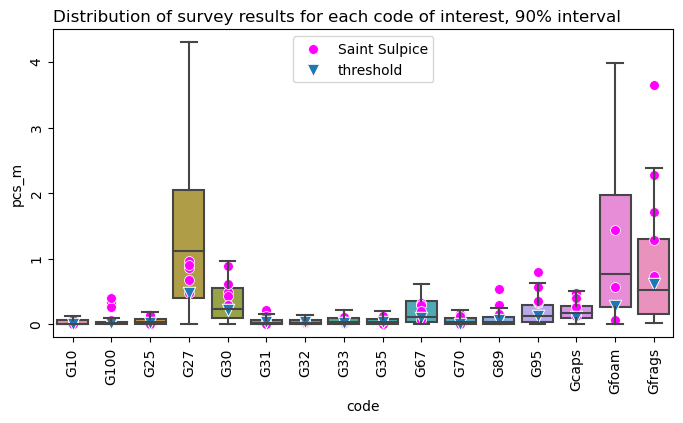

In [36]:
# sample totals per code all locations in city

city_results = yearthree.testwo.current_data[yearthree.testwo.current_data.city == coi]
city_tot = city_results.groupby(["loc_date", "date"], as_index=False).pcs_m.sum()
city_start = city_results.groupby(["loc_date", "date", "code"], as_index=False).pcs_m.sum()

fig, ax = plt.subplots(figsize=(8,4))

sns.boxplot(data=cstart, x="code", y="pcs_m", showfliers=False,ax=ax, width=.8, dodge=True)

sns.scatterplot(data=city_start, x="code", y="pcs_m", ax=ax,s=50, color="magenta", edgecolor="white", label="Saint Sulpice")
sns.scatterplot(data=tholds, x=tholds.index, y=tholds, ax=ax, marker="v", s=80, label="threshold")
ax.tick_params(rotation=90)
ax.set_ylim(-.2, 4.5)
ax.set_title("Distribution of survey results for each code of interest, 90% interval", loc="left")

plt.show()

In [37]:
# fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

# one = axs[0]
# two = axs[1]

# months = mdates.MonthLocator(interval=1)
# months_fmt = mdates.DateFormatter('%b')
# one.xaxis.set_major_locator(months)
# one.xaxis.set_major_formatter(months_fmt)

# one.tick_params(rotation=90)


# sns.scatterplot(data=ctot, x="date", y="pcs_m", ax=one)
# sns.scatterplot(data=city_tot, x="date", y="pcs_m", ax=one, color="magenta")
# sns.ecdfplot(data=ctot, x="pcs_m", ax=two)
# one.set_xlabel("")
# one.set_ylabel("pcs/m")
# one.set_title("Survey total objects of interest", loc="left")

# two.set_title("Empirical cumulative distribution", loc="left")
# two.set_xlabel("pcs/m")

# plt.tight_layout()


# plt.show()

In [38]:
# caption_yone = "Table year one"
# yearone.testwo_post.table_display().style.format(precision=2).background_gradient(axis=None, vmin=0, vmax=1, cmap='YlOrRd').set_caption(caption_yone).set_table_styles(table_css_styles)

In [39]:
# testwo_post.table_display().style.format(precision=2).background_gradient(axis=None, vmin=0, vmax=1, cmap='YlOrRd').set_caption(caption_yone).set_table_styles(table_css_styles)

In [40]:
# city_results = yearone.testwo_post.current_data[yearone.testwo_post.current_data.city ==  'Saint-Sulpice (VD)'].copy()
# prior_luse = {x:city_results[x].drop_duplicates().astype(int).values for x in uses if x in city_results.columns}
# somekeys = prior_luse.keys()
# strs = [yearone.testwo_post.prior_data[yearone.testwo_post.prior_data[x].isin(prior_luse[x])] for x in somekeys]
# strsi = pd.concat(strs)

# xt = an_array_of_posterior_probabilities(city_results, strsi, cois, xrange)
# xq = an_array_of_posterior_probabilities(city_results, uniformed_prior, cois, xrange)

# tc = np.round([xt[i].loc[int(tholds_r.loc[x])]["post"] for i, x in enumerate(cois)], 2)
# tq = np.round([xq[i].loc[int(tholds_r.loc[x])]["post"] for i, x in enumerate(cois)], 2)

# pofsp_year_one = pd.DataFrame(data=[tc, tq], columns=cois, index = ["informed prior", "uniformed prior"])
# caption = "sp year one"

# display_year_one_sp = pofsp_year_one.style.format(precision=2).background_gradient(axis=None, vmin=0, vmax=1, cmap='YlOrRd').set_caption(caption).set_table_styles(table_css_styles)
# display_year_one_sp

In [41]:
slr_d = make_date_object("2017-04-01")
slr_e = make_date_object("2018-05-01")
date_mask = (all_data["date"] >= slr_d) & (all_data["date"] <= slr_e)

lake_locations = all_data[date_mask & (all_data.water_name_slug == 'lac-leman')].location.unique()
prior_locations = all_data[(all_data["date"] <= slr_e)&(all_data.water == "l")].location.unique()

# the survey results and land use attributes associated with the locations
# included in the survey results
p_results, p_ludata = results_and_land_use(all_data, land_use_agg, slr_e, prior_locations, cois)
c_results = p_results[p_results.date >= slr_d ]

lagi2 = survey_results_with_land_use(c_results, p_ludata, lake_locations)
pagi2 = survey_results_with_land_use(p_results, p_ludata, prior_locations)

city_results = c_results[c_results.city == coi]
uses = p_ludata.use.unique()

# sample totals per code
ctot = c_results.groupby(["loc_date", "date"], as_index=False).pcs_m.sum()
city_tot = city_results.groupby(["loc_date", "date"], as_index=False).pcs_m.sum()
city_start = city_results.groupby(["loc_date", "date", "code"], as_index=False).pcs_m.sum()
cstart = c_results.groupby(["loc_date", "date", "code"], as_index=False).pcs_m.sum()
cmedian = cstart.groupby("code", as_index=False).pcs_m.mean()

In [42]:
# fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

# one = axs[0]
# two = axs[1]

# months = mdates.MonthLocator(interval=1)
# months_fmt = mdates.DateFormatter('%b')
# one.xaxis.set_major_locator(months)
# one.xaxis.set_major_formatter(months_fmt)

# one.tick_params(rotation=90)


# sns.scatterplot(data=ctot, x="date", y="pcs_m", ax=one)
# sns.scatterplot(data=city_tot, x="date", y="pcs_m", ax=one, color="magenta")
# sns.ecdfplot(data=ctot, x="pcs_m", ax=two)
# one.set_xlabel("")
# one.set_ylabel("pcs/m")
# one.set_title("Survey total objects of interest", loc="left")

# two.set_title("Empirical cumulative distribution", loc="left")
# two.set_xlabel("pcs/m")

# plt.tight_layout()


# plt.show()

In [43]:
# uniformed_prior = [0.5 for x in xrange]
# year_one_prior = [x.post.values for x in qt]
# t2 = an_array_of_posterior_probabilities(lagi2, pagi2, cois, xrange)
# qt2 = an_array_of_posterior_probabilities(lagi2, uniformed_prior, cois, xrange)
# st2 = an_array_of_sequential_probabilities(lagi2, year_one_prior, cois, xrange)

# tp2 = np.round([t2[i].loc[int(tholds_r.loc[x])]["post"] for i, x in enumerate(cois)], 2)
# qp2 = np.round([qt2[i].loc[int(tholds_r.loc[x])]["post"] for i, x in enumerate(cois)], 2)
# sp2 = np.round([st2[i].loc[int(tholds_r.loc[x])]["post"] for i, x in enumerate(cois)], 2)

# pofx_year_two = pd.DataFrame(data=[tp2, qp2,sp2], columns=cois, index = ["informed prior", "uniformed prior", "year one prior"])

# caption = "Table year two"

# display_year_two = pofx_year_two.style.format(precision=2).background_gradient(axis=None, vmin=0, vmax=1, cmap='YlOrRd').set_caption(caption).set_table_styles(table_css_styles)
# display_year_two

In [44]:
# fig, ax = plt.subplots(figsize=(8,4))

# sns.boxplot(data=cstart, x="code", y="pcs_m", showfliers=False,ax=ax, width=.8, dodge=True)

# sns.scatterplot(data=city_start, x="code", y="pcs_m", ax=ax,s=50, color="magenta", edgecolor="white", label="Saint Sulpice")
# sns.scatterplot(data=tholds, x=tholds.index, y=tholds, ax=ax, marker="v", s=80, label="threshold")
# ax.tick_params(rotation=90)
# ax.set_ylim(-.2, 3)
# ax.set_title("Distribution of survey results for each code of interest, 90% interval", loc="left")

# plt.show()

In [45]:
# city_results2 = lagi2[lagi2.city ==  'Saint-Sulpice (VD)'].copy()
# prior_luse2 = {x:city_results2[x].drop_duplicates().astype(int).values for x in uses if x in city_results2.columns}
# somekeys = prior_luse.keys()
# strs2 = [pagi2[pagi2[x].isin(prior_luse[x])] for x in somekeys]
# strsi2 = pd.concat(strs)
# strsi2

# xt2 = an_array_of_posterior_probabilities(city_results2, strsi2, cois, xrange)
# xq2 = an_array_of_posterior_probabilities(city_results2, uniformed_prior, cois, xrange)
# yone_prior = an_array_of_sequential_probabilities(city_results2, xq, cois, xrange)



# tc2 = np.round([xt2[i].loc[int(tholds_r.loc[x])]["post"] for i, x in enumerate(cois)], 2)
# tq2 = np.round([xq2[i].loc[int(tholds_r.loc[x])]["post"] for i, x in enumerate(cois)], 2)
# tytwo = np.round([yone_prior[i].loc[int(tholds_r.loc[x])]["post"] for i, x in enumerate(cois)], 2)

# pofsp_year_two = pd.DataFrame(data=[tc2, tq2, tytwo], columns=cois, index = ["informed prior", "uniformed prior", "year one prior"])
# caption = "sp year two"

# display_year_two_sp = pofsp_year_two.style.format(precision=2).background_gradient(axis=None, vmin=0, vmax=1, cmap='YlOrRd').set_caption(caption).set_table_styles(table_css_styles)
# display_year_two_sp

In [46]:
# slr_d = make_date_object("2020-04-01")
# slr_e = make_date_object("2021-05-01")
# date_mask =  (all_data["date"] >= slr_d) & (all_data["date"] <= slr_e)

# lake_locations = all_data[date_mask & (all_data.water_name_slug == 'lac-leman')].location.unique()
# prior_locations = all_data[(all_data["date"] <= slr_e) &(all_data.water_name_slug == 'lac-leman')].location.unique()

# # the survey results and land use attributes associated with the locations
# # included in the survey results
# p_results, p_ludata = results_and_land_use(all_data, land_use_agg, slr_e, prior_locations, cois)

# c_results = p_results[p_results.date >= slr_d ]

# lagi3 = survey_results_with_land_use(c_results, p_ludata, lake_locations)
# pagi3 = survey_results_with_land_use(p_results, p_ludata, prior_locations)
# city_results = c_results[c_results.city == coi]
# uses = p_ludata.use.unique()

# # sample totals per code
# ctot = c_results.groupby(["loc_date", "date"], as_index=False).pcs_m.sum()
# city_tot = city_results.groupby(["loc_date", "date"], as_index=False).pcs_m.sum()
# city_start = city_results.groupby(["loc_date", "date", "code"], as_index=False).pcs_m.sum()
# cstart = c_results.groupby(["loc_date", "date", "code"], as_index=False).pcs_m.sum()
# cmedian = cstart.groupby("code", as_index=False).pcs_m.mean()

In [47]:
# fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

# one = axs[0]
# two = axs[1]

# months = mdates.MonthLocator(interval=1)
# months_fmt = mdates.DateFormatter('%b')
# one.xaxis.set_major_locator(months)
# one.xaxis.set_major_formatter(months_fmt)

# one.tick_params(rotation=90)


# sns.scatterplot(data=ctot, x="date", y="pcs_m", ax=one)
# sns.scatterplot(data=city_tot, x="date", y="pcs_m", ax=one, color="magenta")
# sns.ecdfplot(data=ctot, x="pcs_m", ax=two)
# one.set_xlabel("")
# one.set_ylabel("pcs/m")
# one.set_title("Survey total objects of interest", loc="left")

# two.set_title("Empirical cumulative distribution", loc="left")
# two.set_xlabel("pcs/m")

# plt.tight_layout()


# plt.show()

In [48]:
uniformed_prior = [0.5 for x in xrange]
year_two_prior = [x.post.values for x in yeartwo.testwo_post.shared]
# t3 = an_array_of_posterior_probabilities(yearthree.testwo.current_data, yearthree.testwo.prior_data, cois, xrange)
# qt3 = an_array_of_posterior_probabilities(yearthree.testwo.current_data, uniformed_prior, cois, xrange)
# st3 = an_array_of_sequential_probabilities(yearthree.testwo.current_data, year_two_prior, cois, xrange)

# tp3 = np.round([t3[i].loc[int(tholds_r.loc[x])]["post"] for i, x in enumerate(cois)], 2)
# qp3 = np.round([qt3[i].loc[int(tholds_r.loc[x])]["post"] for i, x in enumerate(cois)], 2)
# sp3 = np.round([st3[i].loc[int(tholds_r.loc[x])]["post"] for i, x in enumerate(cois)], 2)

# pofx_year_three = pd.DataFrame(data=[tp3, qp3,sp3], columns=cois, index = ["informed prior", "uniformed prior", "year two prior"])

# caption = "Table year three"

# display_year_three = pofx_year_three.style.format(precision=2).background_gradient(axis=None, vmin=0, vmax=1, cmap='YlOrRd').set_caption(caption).set_table_styles(table_css_styles)
# display_year_three

In [49]:
# fig, ax = plt.subplots()

# for i,res in enumerate(qt3):
#     sns.lineplot(data=res, x="qty", y="post", ax=ax, label=cois[i])
#     # sns.lineplot(data=spc3[i], x="mag", y="p", ax=ax, label=cois[i])

# ax.set_xlabel("pcs per meter")
# ax.set_ylabel("probability of exceeding x")
# ax.legend(bbox_to_anchor=(1,1))
# plt.show()

In [50]:
# fig, ax = plt.subplots(figsize=(8,4))

# sns.boxplot(data=cstart, x="code", y="pcs_m", showfliers=False,ax=ax, width=.8, dodge=True)

# sns.scatterplot(data=city_start, x="code", y="pcs_m", ax=ax,s=50, color="magenta", edgecolor="white", label="Saint Sulpice")
# sns.scatterplot(data=tholds, x=tholds.index, y=tholds, ax=ax, marker="v", s=80, label="threshold")
# ax.tick_params(rotation=90)
# ax.set_ylim(-.2, 4.5)
# ax.set_title("Distribution of survey results for each code of interest, 90% interval", loc="left")
# ax.legend(loc="upper left")

# plt.show()

In [51]:
# city_results3 = lagi3[lagi3.city ==  'Saint-Sulpice (VD)'].copy()
# prior_luse3 = {x:city_results3[x].drop_duplicates().astype(int).values for x in uses if x in city_results3.columns}
# somekeys = prior_luse.keys()
# strs3 = [pagi3[pagi3[x].isin(prior_luse[x])] for x in somekeys]
# strsi3 = pd.concat(strs3)

# xt3 = an_array_of_posterior_probabilities(city_results3, strsi3, cois, xrange)
# xq3 = an_array_of_posterior_probabilities(city_results3, uniformed_prior, cois, xrange)
# ytwo_prior = an_array_of_sequential_probabilities(city_results3, xq2, cois, xrange)

# tc3 = np.round([xt3[i].loc[int(tholds_r.loc[x])]["post"] for i, x in enumerate(cois)], 2)
# tq3 = np.round([xq3[i].loc[int(tholds_r.loc[x])]["post"] for i, x in enumerate(cois)], 2)
# tythree = np.round([ytwo_prior[i].loc[int(tholds_r.loc[x])]["post"] for i, x in enumerate(cois)], 2)

# pofsp_year_three = pd.DataFrame(data=[tc3,  tythree, tq3], columns=cois, index = ["informed prior", "year one prior", "uniformed prior"])
# caption = "sp year three"

# display_year_three_sp = pofsp_year_three.style.format(precision=2).background_gradient(axis=None, vmin=0, vmax=1, cmap='YlOrRd').set_caption(caption).set_table_styles(table_css_styles)
# display_year_three_sp

In [52]:
# pofsp_all_uin = pd.DataFrame(data=[qp,  qp2, qp3], columns=cois, index = ["mcbp", "slr", "iqaasl"])

# caption = "Probability of exceeding threshhold by sampling campaign: uninformed prior"

# pofsp_all = pofsp_all_uin.style.format(precision=2).background_gradient(axis=None, vmin=0, vmax=1, cmap='YlOrRd').set_caption(caption).set_table_styles(table_css_styles)
# pofsp_all

In [53]:
# pofsp_all_inf = pd.DataFrame(data=[tp,  tp2, tp3], columns=cois, index = ["mcbp", "slr", "iqaasl"])


# caption = "Probability of exceeding threshhold by sampling campaign: informed prior"

# pofsp_inf = pofsp_all_inf.style.format(precision=2).background_gradient(axis=None, vmin=0, vmax=1, cmap='YlOrRd').set_caption(caption).set_table_styles(table_css_styles)
# pofsp_inf

In [54]:
# pofsp_all_inf = pd.DataFrame(data=[qp,  sp2, sp3], columns=cois, index = ["mcbp", "slr", "iqaasl"])


# caption = "Probability of exceeding threshhold by sampling campaign: sequential prior"

# pofsp_inf = pofsp_all_inf.style.format(precision=2).background_gradient(axis=None, vmin=0, vmax=1, cmap='YlOrRd').set_caption(caption).set_table_styles(table_css_styles)
# pofsp_inf

In [55]:
# from scipy.stats import spearmanr

# spr_mn = lagi.copy()
# spr_mnpr = pagi.copy()
# x, y = spr_mn[spr_mn.code == "G27"].pcs_m.values, spr_mn[spr_mn.code == "G27"]["Siedl"].astype("int").values
# xp, yp = spr_mnpr[spr_mnpr.code == "G27"].pcs_m.values, spr_mnpr[spr_mnpr.code == "G27"]["Siedl"].astype("int").values
# sprmn_rho_lake = spearmanr(x,y)
# sprmn_rho_prior = spearmanr(xp, yp)

# print((sprmn_rho_lake.statistic, sprmn_rho_lake.pvalue), (sprmn_rho_prior.pvalue, sprmn_rho_prior.pvalue))

## Samples after May 2021

### Expected results for Saint Sulpice

__Observed results October 2021: SWE__

In [56]:
def is_in_range(x, arange):
    acount = 0
    lows = 0
    highs = 0
    
    if isinstance(x, float):    
        gthan = x >= arange[1]
        lthan = x <= arange[2]
        if gthan and lthan:
            ontarget = True
            dif = 0
            acount += 1
        elif not gthan:
            ontarget = "high"
            dif = arange[1] - x
            highs += 1
            
        elif not lthan:
            ontarget = "low"
            dif = arange[2] - x
            lows += 1
    else:
        ontarget = "No data"
        dif = None
    
    return arange[0], ontarget, dif, acount, highs, lows


lake_after_may = all_data[(all_data.date > slr_e) & (all_data.water_name_slug == 'lac-leman')]
after_may_location = lake_after_may.location.unique()
l_a_m = lake_after_may[lake_after_may.code.isin(cois)]
l_a_mx = l_a_m[l_a_m.location.isin(['plage-de-st-sulpice', 'tiger_duck_beach'])]
lam = l_a_mx.groupby("code", as_index=False).pcs_m.mean()
lm = pd.DataFrame(data=lam.pcs_m.values, index=lam.code).T
xlmc = lm[cois]
xlmcv = xlmc.values[0]
xlmc

code,Gfrags,G30,G27,Gfoam,G95,Gcaps,G67,G35,G89,G31,G32,G100,G33,G25,G70,G10
0,1.41,0.42,0.375,0.035,0.255,0.215,0.095,0.05,0.16,0.075,0.025,0.085,0.01,0.075,0.09,0.04


#### The probability of the observed results at Saint Sulpice given the informed posterior from lake

The observed results +/- .1. See table 12 for probability of the event at the lake.

In [57]:
# # the probability of the result after may 2021
# h = [x.loc[(x.qty >= xlmcv[i] - .1)&(x.qty <= xlmcv[i] + .1)] for i, x in enumerate(xq3)]
# hg = [(cois[i],np.round(x.post.min(), 2), np.round(x.post.max(), 2)) for i, x in enumerate(h)]

# # the expected range magnitude with a 96% probability
# t = [x.loc[(x.post >= .03) & (x.post <= .97)].qty for i, x in enumerate(xq3)]
# tr = [(cois[i], round(x.min(), 2),  round(x.max(), 2)) for i,x in enumerate(t)]

# tested = [is_in_range(xlmcv[i], x) for i, x in enumerate(tr)]
# print("\nDid the observed results fall within the predicted range?")
# in_range = sum([x[3] for x in tested])
# arange = len(tested)
# highs = sum([x[4] for x in tested])
# lows = sum([x[5] for x in tested])
# print(f"In range: {in_range}, out of: {arange}\n")
# print(f"Estmiated high: {highs}, Estimated low: {lows}")

#### The probability of the observed results at Saint Sulpice given the informed posterior from Saint Sulpice

The observed results +/- .1. See table 14 for the probability of the event at Saint Sulpice.

In [58]:
# # saint sulpice
# # the probability of the result after may 2021
# h = [x.loc[(x.qty >= xlmcv[i] - .1) & (x.qty <= xlmcv[i] + .1)].post for i, x in enumerate(xt3)]
# # [(cois[i], round(x.min(), 2), round(x.max(), 2)) for i, x in enumerate(h)]

# # the expected magnitude with probability between .3 and .6
# a_p_for_index = xt3
# t = [x.loc[(x.post >= .03) & (x.post <= .97)].qty for i, x in enumerate(a_p_for_index)]
# tr = [(cois[i], round(x.min(), 2),  round(x.max(), 2)) for i,x in enumerate(t)]


# # pstk_gfrags = pstock[pstock.code == "Gfrags"].copy()
# # pstk_res = pstk_gfrags["pcs/m"].values

# tested = [is_in_range(xlmcv[i], x) for i, x in enumerate(tr)]
# print("\nDid the observed results fall within the predicted range?")
# in_range = sum([x[3] for x in tested])
# arange = len(tested)
# highs = sum([x[4] for x in tested])
# lows = sum([x[5] for x in tested])
# # print(f"96% probability range = {tr[0]}")
# print(f"In range: {in_range}, out of: {arange} or {round(in_range/arange, 2)}\n")
# print(f"Estmiated high: {highs}, Estimated low: {lows}")

### Plastock

100 samples from 2022 on lac leman

In [59]:
plastock = pd.read_csv("resources/pstock_2022.csv")
plastock["loc_date"] = list(zip(plastock.location, plastock.date))
pstock = plastock[plastock.code.isin(cois)].copy()
pstock = pstock.groupby(["loc_date", "location", "date", "code"], as_index=False)["pcs/m"].sum()
pstock = pstock.groupby(["location", "code"], as_index=False)["pcs/m"].mean()

In [60]:
a_p_for_index = yearthree.testwo_post.shared
t = [x.loc[(x.post >= .03) & (x.post <= .97)].qty for i, x in enumerate(a_p_for_index)]
tr = [(cois[i], round(x.min(), 2),  round(x.max(), 2)) for i,x in enumerate(t)]

pstk_gfrags = pstock[pstock.code == "Gfrags"].copy()
pstk_res = pstk_gfrags["pcs/m"].values

tested = [is_in_range(x, tr[0]) for x in pstk_res]

print("\nDid the observed results fall within the predicted range?")
in_range = sum([x[3] for x in tested])
arange = len(tested)
highs = sum([x[4] for x in tested])
lows = sum([x[5] for x in tested])
print(f"96% probability range = {tr[0]}")
print(f"In range: {in_range}, out of: {arange} or {round(in_range/arange, 2)}\n")
print(f"Estmiated high: {highs}, Estimated low: {lows}")


Did the observed results fall within the predicted range?
96% probability range = ('Gfrags', 0.06, 1.58)
In range: 16, out of: 25 or 0.64

Estmiated high: 0, Estimated low: 9


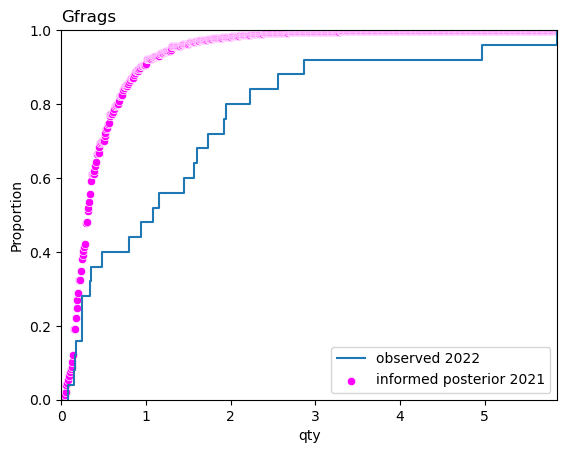

In [61]:
d = a_p_for_index[0]
d["1-p"] = 1- d.post

fig, ax = plt.subplots()

sns.ecdfplot(pstk_res, ax=ax, label="observed 2022")
sns.scatterplot(data=d, x="qty", y="1-p", ax=ax, color="magenta", label="informed posterior 2021")
ax.set_xlim(0, pstk_res.max())
ax.set_title(cois[0], loc="left")

plt.show()

In [62]:
pstk_gfrags = pstock[pstock.code == "G27"].copy()
pstk_res = pstk_gfrags["pcs/m"].values

tested = [is_in_range(x, tr[2]) for x in pstk_res]
print("\nDid the observed results fall within the predicted range?")
in_range = sum([x[3] for x in tested])
arange = len(tested)
highs = sum([x[4] for x in tested])
lows = sum([x[5] for x in tested])
print(f"96% probability range = {tr[2]}")
print(f"In range: {in_range}, out of: {arange} or {round(in_range/arange, 2)}\n")
print(f"Estmiated high: {highs}, Estimated low: {lows}")


Did the observed results fall within the predicted range?
96% probability range = ('G27', 0.06, 1.8)
In range: 20, out of: 25 or 0.8

Estmiated high: 4, Estimated low: 1


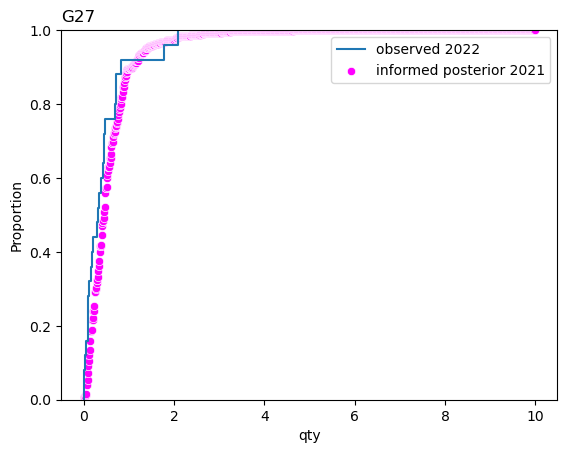

In [63]:
d = a_p_for_index[2]
d["1-p"] = 1- d.post

fig, ax = plt.subplots()

sns.ecdfplot(pstk_res, ax=ax, label="observed 2022")
sns.scatterplot(data=d, x="qty", y="1-p", ax=ax, color="magenta", label="informed posterior 2021")
ax.set_title(cois[2], loc="left")

plt.show()

In [64]:
pstk_gfrags = pstock[pstock.code == "G95"].copy()
pstk_res = pstk_gfrags["pcs/m"].values

tested = [is_in_range(x, tr[4]) for x in pstk_res]
print("\nDid the observed results fall within the predicted range?")
in_range = sum([x[3] for x in tested])
arange = len(tested)
highs = sum([x[4] for x in tested])
lows = sum([x[5] for x in tested])
print(f"96% probability range = {tr[4]}")
print(f"In range: {in_range}, out of: {arange} or {round(in_range/arange, 2)}\n")
print(f"Estmiated high: {highs}, Estimated low: {lows}")


Did the observed results fall within the predicted range?
96% probability range = ('G95', 0.01, 0.53)
In range: 15, out of: 25 or 0.6

Estmiated high: 8, Estimated low: 2


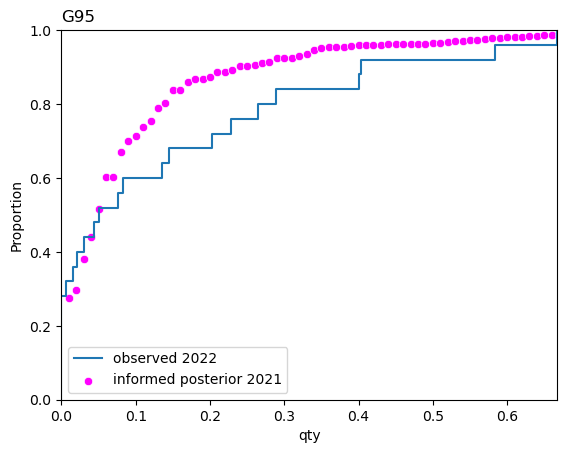

In [65]:
d = a_p_for_index[4]
d["1-p"] = 1- d.post 

fig, ax = plt.subplots()

sns.ecdfplot(pstk_res, ax=ax, label="observed 2022")
sns.scatterplot(data=d, x="qty", y="1-p", ax=ax, color="magenta", label="informed posterior 2021")
ax.set_xlim(0, pstk_res.max())
ax.set_title(cois[4], loc="left")

plt.show()

#### Expected values and predictions plastock

In [66]:
plastock = pd.read_csv("resources/pstock_2022.csv")
plastock["loc_date"] = list(zip(plastock.location, plastock.date))
pstock = plastock[plastock.code.isin(cois)].copy()
pstock = pstock.groupby(["loc_date", "location", "date", "code"], as_index=False)["pcs/m"].sum()
pstock = pstock.groupby(["location", "code"], as_index=False)["pcs/m"].mean()
t3 = an_array_of_posterior_probabilities(yearthree.testwo.current_data, yearthree.testwo.prior_data, cois, xrange)
a_p_for_index = t3
t = [x.loc[(x.post >= .03) & (x.post <= .97)].qty for i, x in enumerate(a_p_for_index)]
tr = [(cois[i], round(x.min(), 2),  round(x.max(), 2)) for i,x in enumerate(t)]

pst = [np.round(pstock[pstock.code == x]["pcs/m"].values, 2) for x in cois]

n = 0
inn = 0
ress = []
for i,x in enumerate(pst):
    tested = [is_in_range(j, tr[i]) for j in x]
    # print("\nDid the observed results fall within the predicted range?")
    in_range = sum([k[3] for k in tested])
    arange = len(tested)
    n += arange
    inn += in_range
    highs = sum([x[4] for x in tested])
    lows = sum([x[5] for x in tested])
    arow = {"code":tr[i][0],"rlow":tr[i][1], "rhigh":tr[i][2], "o-mean":round(np.mean(x), 2), "in range":in_range, "plow":lows, "phigh":highs}
    ress.append(arow)
    # print(f"96% probability range = {tr[i]}")
    # print(f"In range: {in_range}, out of: {arange} or {round(in_range/arange, 2)}\n")
    # print(f"Estmiated high: {highs}, Estimated low: {lows}")
    # print(n, inn)

rest = pd.DataFrame(ress)
rest["o mean in range"] = (rest["o-mean"] >= rest.rlow) & (rest["o-mean"] <= rest.rhigh)
rest["object"] = rest.code.apply(lambda x: code_d.loc[x])
rest = rest[["object", *rest.columns[:-1]]]
rest.set_index("code", inplace=True, drop=True)
rest

,object,rlow,rhigh,o-mean,in range,plow,phigh,o mean in range
code,,,,,,,,
Gfrags,Fragmented plastics,0.06,1.58,1.41,16,9,0,True
G30,"Food wrappers; candy, snacks",0.05,0.62,0.28,20,1,4,True
G27,Cigarette filters,0.06,1.48,0.43,19,2,4,True
Gfoam,Expanded polystyrene,0.01,1.16,0.21,20,1,4,True
G95,Cotton bud/swab sticks,0.01,0.52,0.15,16,2,7,True
Gcaps,Plastic bottle lids,0.01,0.42,0.14,18,1,6,True
G67,Industrial sheeting,0.01,0.50,0.02,4,0,21,True
G35,Straws and stirrers,0.01,0.12,0.02,15,1,9,True
G89,Plastic construction waste,0.01,0.20,0.05,12,2,11,True


In [67]:
good_p = rest["o mean in range"].sum()
rate_goodp = good_p/len(rest)

print(f"Percent within predicted range: {np.round(rate_goodp, 2)}")

Percent within predicted range: 0.81


#### Mix of objects, % of total

In [68]:
# coi % of total
code_totals = plastock.groupby("code", as_index=False).quantity.sum()
code_totals["%"] = code_totals.quantity/code_totals.quantity.sum()
ct_i = code_totals[code_totals.code.isin(cois)].sort_values(by="%", ascending=False)

lake_ythree = all_data[date_mask & (all_data.water_name_slug == 'lac-leman')].copy()
lake_y3 = lake_ythree.groupby("code", as_index=False).quantity.sum()
lake_y3["%"] = lake_y3.quantity/lake_y3.quantity.sum()
lake_y3i = lake_y3[lake_y3.code.isin(cois)].sort_values(by="%", ascending=False)

l_a_mx = all_data[all_data.location.isin(['plage-de-st-sulpice', 'tiger_duck_beach'])]
sp_x = l_a_mx.groupby("code", as_index=False).quantity.sum()
sp_x["%"] = sp_x.quantity/sp_x.quantity.sum()
sp_xi = sp_x[sp_x.code.isin(cois)].sort_values(by="%", ascending=False)
sp_xi.rename(columns={"%":"SWE %"}, inplace=True)
sp_xi.set_index("code", inplace=True, drop=True)



code_totals.rename(columns={"%":"plastock %"}, inplace=True)
lake_y3.rename(columns={"%":"lake %"}, inplace=True)

res_pct = code_totals[["code", "plastock %"] ].merge(lake_y3[["code", "lake %"]], on="code")
res_pct = res_pct[res_pct.code.isin(cois)].sort_values(by="plastock %", ascending=False)
res_pct.set_index("code", inplace=True, drop=True)
res_pct = res_pct.merge(sp_xi["SWE %"], left_index=True, right_index=True)
res_pct.apply(lambda x: round(x*100, 2))

,plastock %,lake %,SWE %
code,,,
Gfrags,40.16,6.81,15.74
G27,11.67,27.21,10.10
G30,7.35,8.76,8.60
Gfoam,4.97,4.93,4.17
Gcaps,3.88,3.72,2.58
G95,3.67,8.43,7.60
G89,1.48,1.81,1.73
G31,1.33,1.11,0.79
G70,0.70,0.56,0.50


In [69]:
lfmay = lake_after_may.copy()

__Percent of all identified objects concerned by these results__

In [70]:
res_pct.sum()

plastock %    0.767988
lake %        0.741737
SWE %         0.582501
dtype: float64

In [71]:
today = dt.datetime.now().date().strftime("%d/%m/%Y")
where = "Biel, CH"

my_block = f"""

This script updated {today} in {where}

> \u2764\ufe0f what you do everyday

*analyst at hammerdirt*
"""

md(my_block)



This script updated 17/07/2023 in Biel, CH

> ❤️ what you do everyday

*analyst at hammerdirt*


In [72]:
%watermark --iversions -b -r

Git repo: https://github.com/hammerdirt-analyst/patelmanuscript.git

Git branch: newsummary

pandas    : 2.0.2
seaborn   : 0.12.2
scipy     : 1.10.1
numpy     : 1.24.3
matplotlib: 3.7.1

